In [1]:
import jax.numpy as jnp
import jax
import jaxdem as jd
jax.config.update("jax_enable_x64", True)
import numpy as np
import os
import matplotlib.pyplot as plt

In [6]:
data_root = '/home/mmccraw/dev/data/26-01-01/grant/debugging-cell-list/3d/rad-0.4-cm-1.1/'
state_traj = jd.utils.h5.load(os.path.join(data_root, 'state.h5'))
system_traj = jd.utils.h5.load(os.path.join(data_root, 'system.h5'))

pe = jax.vmap(jd.utils.thermal.compute_potential_energy)(state_traj, system_traj)
ke_t = jax.vmap(jd.utils.thermal.compute_translational_kinetic_energy)(state_traj)
ke_r = jax.vmap(jd.utils.thermal.compute_rotational_kinetic_energy)(state_traj)
te = pe + ke_r + ke_t

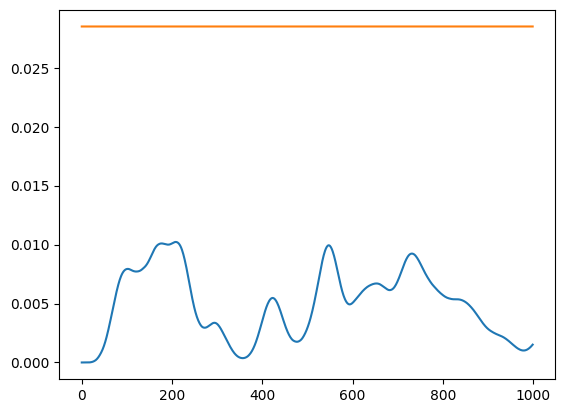

In [7]:
plt.plot(pe)
plt.plot(te)
# ax[1].plot(np.diff(traj_system.collider.n_build_times) * np.max(te), zorder=0)
bad_indices = np.argwhere(np.abs(np.diff(te)) > 1e-6).flatten()
plt.scatter(bad_indices, te[bad_indices])

In [28]:
# cutoff = float(system_traj.collider.cell_size[0])
cutoff = jnp.max(state_traj.rad) * 2.0
cutoff_sq = cutoff ** 2
max_neighbors = 40
st, sy, nl_full, ovr = jax.vmap(lambda st, sy: sy.collider.create_neighbor_list(st, sy, cutoff, max_neighbors))(state_traj, system_traj)
jnp.max(jnp.sum(nl_full != -1, axis=-1)), jnp.any(ovr)

(Array(24, dtype=int64), Array(False, dtype=bool))

In [29]:
def check_missing_ids(pos, bs, clump_ID, nl_true):
    dr = pos[:, None, :] - pos[None, ...]
    dr -= bs * jnp.round(dr / bs)
    r = jnp.linalg.norm(dr, axis=-1)
    id_i, id_j = jnp.triu_indices_from(r, k=1)
    clump_mask = clump_ID[id_i] != clump_ID[id_j]
    neighbor_mask = r[id_i, id_j][clump_mask] <= cutoff
    id_i = id_i[clump_mask][neighbor_mask]
    id_j = id_j[clump_mask][neighbor_mask]
    ids = jnp.column_stack((id_i, id_j))

    nl_ids = []
    for nl_id_i, nl_i in enumerate(nl_true):
        for nl_id_j in nl_i:
            if nl_id_i != -1 and nl_id_j != -1:
                nl_ids.append([nl_id_i, nl_id_j])
    nl_ids = jnp.array(nl_ids)

    missing_ids = []
    for ids in jnp.column_stack((id_i, id_j)):
        if not jnp.any(jnp.all(nl_ids == ids, axis=-1)):
            print(f'Missing pairs {ids}')
            missing_ids.append(ids)
    return missing_ids

In [33]:
if bad_indices.size == 0:
    ids = [0]
else:
    ids = bad_indices
for i in ids:
    k = i
    pos = state_traj.pos[k]
    bs = system_traj.domain.box_size[k]
    nl = nl_full[k]
    clump_ID = state_traj.clump_ID[k]
    unique_ID = state_traj.unique_ID[k]

    check_missing_ids(pos, bs, clump_ID, nl)
    break

In [15]:
pos.shape

(120, 3)

In [38]:
cell_size = float(system_traj.collider.cell_size[0])
neighbor_mask = system_traj.collider.neighbor_mask[0]
# get spatial partition
iota = jax.lax.iota(int, state_traj.N)
grid_dims = jnp.floor(bs / cell_size).astype(int)
grid_strides = jnp.concatenate([jnp.array([1], dtype=int), jnp.cumprod(grid_dims[:-1])])
# assign cell ids (my way)
cell_coords = jnp.floor(((pos / bs) % 1) * grid_dims).astype(int)
cell_ids = jnp.dot(cell_coords, grid_strides)

# sort (SKIPPED FOR NOW TO PRESERVE THE SAME ORDERING AS THE PREVIOUS NEIGHBOR LIST)
cell_ids, perm = jax.lax.sort([cell_ids, iota], num_keys=1)
cell_coords = cell_coords[perm]

# calculate neighboring cell ids
neighbor_cell_coords = cell_coords[:, None, :] + neighbor_mask
neighbor_cell_coords -= grid_dims * jnp.floor(neighbor_cell_coords / grid_dims).astype(int)  # apply pbc
neighbor_cell_ids = jnp.dot(neighbor_cell_coords, grid_strides)

_pos = pos[perm]
_clump_ID = clump_ID[perm]
_unique_ID = unique_ID[perm]

In [41]:
neighbor_cell_ids[0]

Array([13, 22,  4, 13, 22, 16, 25,  7, 16, 25, 10, 19,  1, 10, 19, 13, 22,
        4, 13, 22, 16, 25,  7, 16, 25, 14, 23,  5, 14, 23, 17, 26,  8, 17,
       26, 11, 20,  2, 11, 20, 14, 23,  5, 14, 23, 17, 26,  8, 17, 26, 12,
       21,  3, 12, 21, 15, 24,  6, 15, 24,  9, 18,  0,  9, 18, 12, 21,  3,
       12, 21, 15, 24,  6, 15, 24, 13, 22,  4, 13, 22, 16, 25,  7, 16, 25,
       10, 19,  1, 10, 19, 13, 22,  4, 13, 22, 16, 25,  7, 16, 25, 14, 23,
        5, 14, 23, 17, 26,  8, 17, 26, 11, 20,  2, 11, 20, 14, 23,  5, 14,
       23, 17, 26,  8, 17, 26], dtype=int64)

In [18]:
cell_size = float(system_traj.collider.cell_size[0])
neighbor_mask = system_traj.collider.neighbor_mask[0]
# get spatial partition
iota = jax.lax.iota(int, state_traj.N)
grid_dims = jnp.floor(bs / cell_size).astype(int)
# assign cell ids (my way)
cell_coords = jnp.floor(((pos / bs) % 1) * grid_dims).astype(int)
cell_ids = cell_coords[:, 0] + cell_coords[:, 1] * grid_dims[0]

# sort (SKIPPED FOR NOW TO PRESERVE THE SAME ORDERING AS THE PREVIOUS NEIGHBOR LIST)
cell_ids, perm = jax.lax.sort([cell_ids, iota], num_keys=1)
cell_coords = cell_coords[perm]

# calculate neighboring cell ids
neighbor_cell_coords = cell_coords[:, None, :] + neighbor_mask
neighbor_cell_coords -= grid_dims * jnp.floor(neighbor_cell_coords / grid_dims).astype(int)  # apply pbc
neighbor_cell_ids = neighbor_cell_coords[..., 0] + neighbor_cell_coords[..., 1] * grid_dims[0]


# perm,
# cell_coords,
# cell_ids,
# neighbor_cell_coords,
# neighbor_cell_ids,

_pos = pos[perm]
_clump_ID = clump_ID[perm]
_unique_ID = unique_ID[perm]

pid = 127
new_pid = jnp.argwhere(_unique_ID == unique_ID[127])[0][0]

neighbor_ids = []
for cell_id in neighbor_cell_ids[pid]:
    ids = jnp.argwhere(cell_ids == cell_id).flatten()
    for neighbor_id in ids[ids != pid]:
        dr = pos[pid] - pos[neighbor_id]
        dr -= bs * jnp.round(dr / bs)
        r = jnp.linalg.norm(dr)
        if r <= cutoff and clump_ID[pid] != clump_ID[neighbor_id]:
            neighbor_ids.append(neighbor_id)

neighbor_ids, nl[pid]

([],
 Array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1], dtype=int64))

In [19]:
def per_particle(idx, pos_i, stencil):
    cell_starts = jnp.searchsorted(cell_ids, stencil, side="left", method="scan_unrolled")
    def stencil_body(target_cell_hash, start_idx):
        local_capacity = max_neighbors // 2 + 1
        init_carry = (
            start_idx,
            jnp.array(0, dtype=int),
            jnp.full((local_capacity,), -1, dtype=int),
        )
        def cond_fun(val):
            k, c, _ = val
            in_cell = (k < state_traj.N) & (cell_ids[k] == target_cell_hash)
            has_space = c < local_capacity
            return in_cell & has_space

        def body_fun(val):
            k, c, nl = val
            # dr = system_traj.domain.displacement(pos_i, pos[k], system)
            dr = pos_i - _pos[k]
            dr -= bs * jnp.round(dr / bs)
            d_sq = jnp.sum(dr**2, axis=-1)
            valid = (
                (_clump_ID[k] != _clump_ID[idx])
                * (d_sq <= cutoff_sq)
            )
            nl = jax.lax.cond(
                valid,
                lambda nl_: nl_.at[c].set(k),
                lambda nl_: nl_,
                nl,
            )
            c = c + valid.astype(c.dtype)
            return k + 1, c, nl
        _, local_c, local_nl = jax.lax.while_loop(cond_fun, body_fun, init_carry)
        return local_nl, local_c

    final_n_list, stencil_counts = jax.vmap(stencil_body)(stencil, cell_starts)
    row_offsets = jnp.cumsum(stencil_counts) - stencil_counts
    local_iota = jnp.arange(final_n_list.shape[1])
    target_indices = row_offsets[:, None] + local_iota[None, :]
    valid_mask = local_iota[None, :] < stencil_counts[:, None]
    safe_indices = jnp.where(valid_mask.flatten(), target_indices.flatten(), max_neighbors)
    result = jnp.full((max_neighbors,), -1, dtype=final_n_list.dtype)
    final_n_list = result.at[safe_indices].set(final_n_list.flatten(), mode="drop")
    return final_n_list, jnp.sum(stencil_counts) > max_neighbors

neighbor_list, overflows = jax.vmap(per_particle)(iota, _pos, neighbor_cell_ids)

In [20]:
check_missing_ids(_pos, bs, _clump_ID, neighbor_list)

[]

In [ ]:
# things to fix:

# missing pairs

# non-integer sized cells
# minimum number of cells

((376, 2), 376)